In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cosine, correlation
from surprise import Reader, Dataset, SVD, BaselineOnly, KNNBasic, NMF, KNNWithMeans
from surprise.model_selection import cross_validate, KFold ,GridSearchCV , RandomizedSearchCV

In [3]:
ratings = pd.read_csv('ml-100k/u.data', sep = '\t', header = None, names = ['user_id', 'movie_id', 'rating', 'timestamp'], encoding = 'utf-8')
user = pd.read_csv('ml-100k/u.user', sep = '|', header = None, names = ['user_id', 'age', 'gender', 'occupation', 'zip_code'], encoding = 'utf-8')
movie = pd.read_csv('ml-100k/u.item', sep = '|', encoding="iso-8859-1", header = None, names = ["movie_id", "movie_title", "release_date", "video_releasedate", "IMDbURL", "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"])
ratings = ratings.drop(columns = ['timestamp'])
print(ratings.shape)
ratings.head()

(100000, 3)


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
user.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [5]:
movie.head()

,movie_id,movie_title,release_date,video_releasedate,IMDbURL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
movie = movie.drop(columns = ["release_date", "video_releasedate", "IMDbURL"])
print(movie.shape)
movie.head()

(1682, 21)


,movie_id,movie_title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
def compress_columns(row, li): 
    l = []
    for i in li:
        if row[i] == 1 :
            l.append(str(i))
    return l    

li_genres = ["unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

movie['genres'] = movie.apply(compress_columns, li = li_genres, axis = 1)#genres sütununu ekledik 

In [8]:
movie["genres"]

0       [Animation, Children's, Comedy]
1         [Action, Adventure, Thriller]
2                            [Thriller]
3               [Action, Comedy, Drama]
4              [Crime, Drama, Thriller]
                     ...               
1677                            [Drama]
1678                [Romance, Thriller]
1679                   [Drama, Romance]
1680                           [Comedy]
1681                            [Drama]
Name: genres, Length: 1682, dtype: object

In [9]:
df = pd.merge(ratings,movie,on='movie_id')
df = df[['user_id', 'movie_id', 'rating', 'movie_title','genres']]
print(df.shape)
df.tail(10)

(100000, 5)


,user_id,movie_id,rating,movie_title,genres
99990,416,1594,5,Everest (1998),[Documentary]
99991,648,1626,1,Nobody Loves Me (Keiner liebt mich) (1994),"[Comedy, Drama]"
99992,655,1645,4,"Butcher Boy, The (1998)",[Drama]
99993,747,1659,1,Getting Away With Murder (1996),[Comedy]
99994,916,1682,3,Scream of Stone (Schrei aus Stein) (1991),[Drama]
99995,840,1674,4,Mamma Roma (1962),[Drama]
99996,655,1640,3,"Eighth Day, The (1996)",[Drama]
99997,655,1637,3,Girls Town (1996),[Drama]
99998,655,1630,3,"Silence of the Palace, The (Saimt el Qusur) (1...",[Drama]
99999,655,1641,3,Dadetown (1995),[Documentary]


In [14]:
print('Toplam oy sayısı:  ' + str(df.user_id.count()))
print('Kullanıcı sayısı:  ' + str(df.user_id.nunique()))
print('Film sayısı:  ' + str(df.movie_id.nunique()))

Toplam oy sayısı:  100000
Kullanıcı sayısı:  943
Film sayısı:  1682


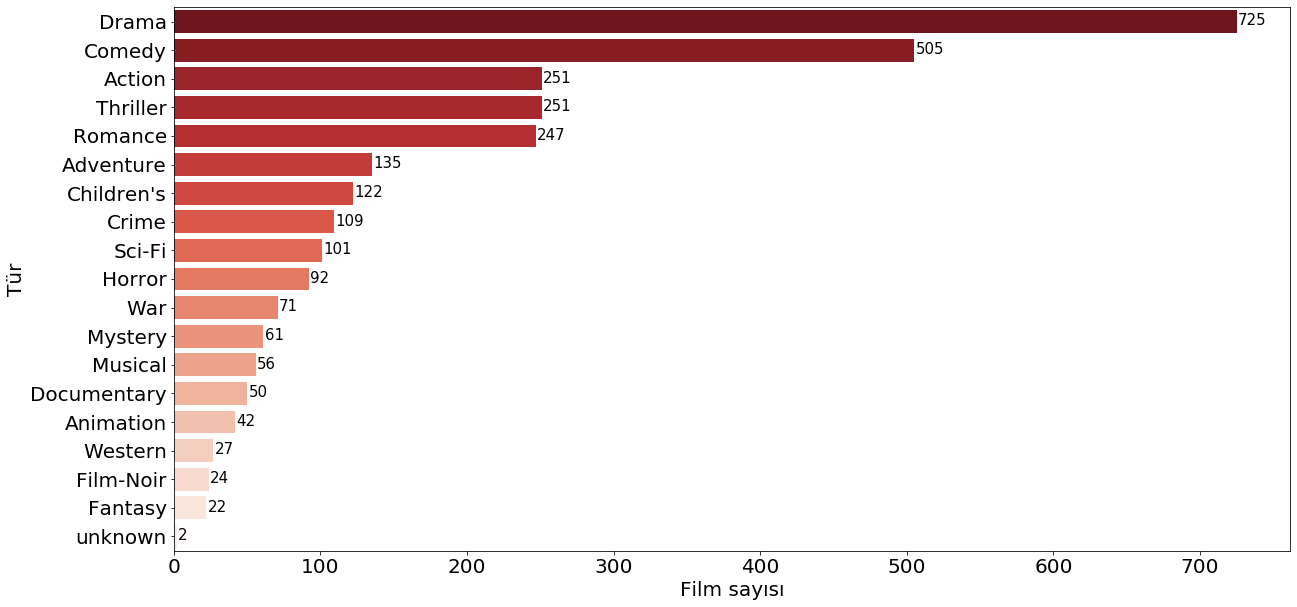

In [16]:
def number_of_genres(x):
    return len(x['genres'])

movie['genres_count'] = movie.apply(number_of_genres,axis = 1)
l = pd.Series(np.concatenate(movie['genres']))
x = pd.Series(l.value_counts())

plt.figure(figsize=(20,10))
ax = sns.barplot(x,x.index,palette='Reds_r')
for p in ax.patches:
        count = '{:.0f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.9
        y = p.get_y() + p.get_height()/1.5
        ax.annotate(count, (x, y), fontsize = 15)
plt.xticks(fontsize = 20)
plt.xlabel('Film sayısı',fontsize=20)
plt.ylabel('Tür', fontsize=20)
plt.yticks(fontsize = 20)
plt.savefig("Turdagılımı.png", bbox_inches='tight')
plt.show()

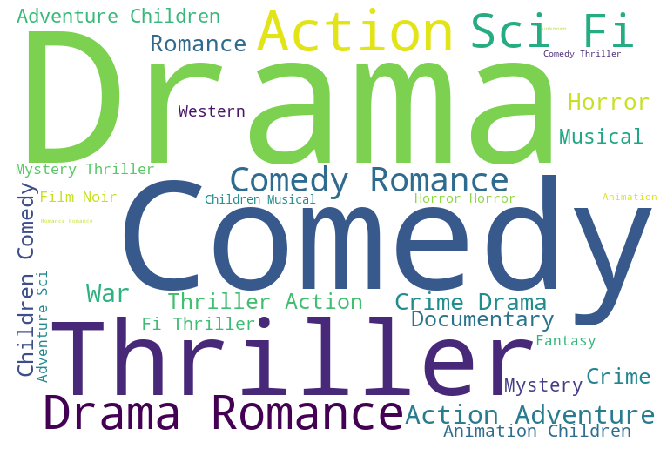

In [17]:
from wordcloud import WordCloud, STOPWORDS
unique_string=(" ").join(l)
wordcloud = WordCloud(width = 750, height = 500, background_color='white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("turcloud.png", bbox_inches='tight')
plt.show()
plt.close()

,genres_count
1,49.5
2,33.8
3,12.8
4,3.0
5,0.7
6,0.2


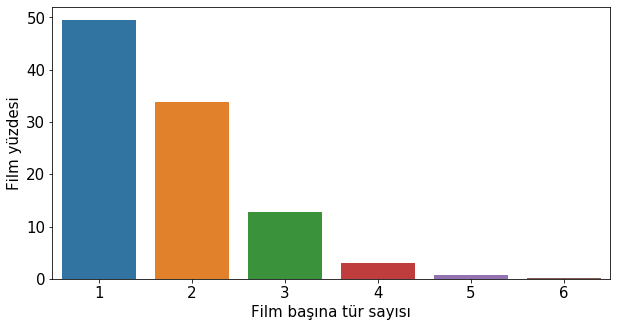

In [18]:
def number_of_genres(x):
    return len(x['genres'])

movie['genres_count'] = movie.apply(number_of_genres,axis = 1)

x = pd.Series(movie['genres_count'].value_counts(normalize=True).mul(100))


plt.figure(figsize=(10,5))
ax = sns.barplot(x.index,x)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Film başına tür sayısı', fontsize = 15)
plt.ylabel('Film yüzdesi', fontsize = 15)

pd.DataFrame(x.sort_values(ascending = False).round(1))

4    34.174
3    27.145
5    21.201
2    11.370
1     6.110
Name: rating, dtype: float64


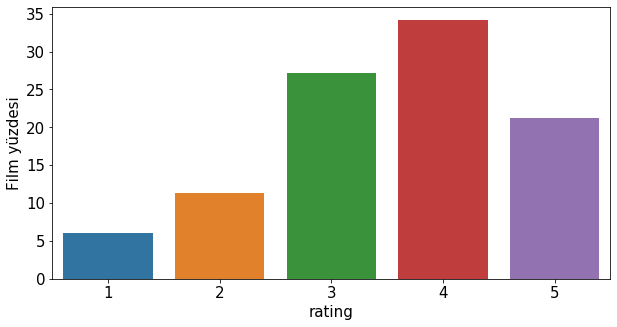

In [23]:
x = pd.Series(df['rating'].value_counts(normalize=True).mul(100))

plt.figure(figsize=(10,5))
ax = sns.barplot(x.index,x)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('rating', fontsize = 15)
plt.ylabel('Film yüzdesi', fontsize = 15)

print(x.sort_values(ascending = False))

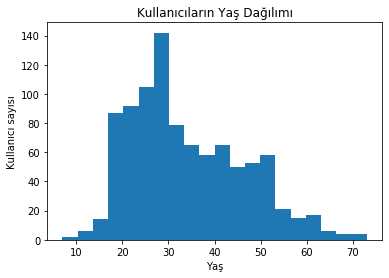

In [24]:
user.age.plot.hist(bins=20)
plt.title("Kullanıcıların Yaş Dağılımı")
plt.ylabel('Kullanıcı sayısı')
plt.xlabel('Yaş');

## Content Based Filtering

In [26]:
movie_genre = movie.drop(columns = ['movie_title', 'genres_count', 'genres','genres_count']).set_index('movie_id')
movie_genre.head()

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [27]:
content_similarity = 1 - pairwise_distances(movie_genre.values, metric='cosine')

In [28]:
movie = movie.set_index('movie_id')
movie.head()

,movie_title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genres,genres_count
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,"[Animation, Children's, Comedy]",3
2,GoldenEye (1995),0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"[Action, Adventure, Thriller]",3
3,Four Rooms (1995),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,[Thriller],1
4,Get Shorty (1995),0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,"[Action, Comedy, Drama]",3
5,Copycat (1995),0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,"[Crime, Drama, Thriller]",3


In [29]:
def content_rec(title, n):   
    idx = movie[movie['movie_title'] == title].index.values
    sorted_movie_index = (-content_similarity[idx[0]-1,:].flatten()).argsort()[:n+1]
    f_index = sorted_movie_index[sorted_movie_index != idx[0]-1]   
    return movie.iloc[f_index,:].movie_title

In [30]:
content_rec('Fargo (1996)', 10)

movie_id
329              Desperate Measures (1998)
649     Once Upon a Time in America (1984)
1213                  Guilty as Sin (1993)
1208                  Kiss of Death (1995)
348              Desperate Measures (1998)
5                           Copycat (1995)
332                  Kiss the Girls (1997)
1069                        Amateur (1994)
914                     Wild Things (1998)
129                           Bound (1996)
Name: movie_title, dtype: object

## Collaborative Filtering

In [37]:
lrating= df["rating"].min()
urating= df["rating"].max()
print("{0} to {1}".format(lrating,urating))

1 to 5


In [31]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'movie_title', 'rating']], reader)

In [32]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9340  0.9297  0.9324  0.9429  0.9311  0.9340  0.0047  
MAE (testset)     0.7345  0.7371  0.7338  0.7434  0.7336  0.7365  0.0037  
Fit time          8.52    8.63    9.49    9.16    7.71    8.70    0.61    
Test time         0.37    0.38    0.30    0.21    0.39    0.33    0.07    


{'test_rmse': array([0.93398528, 0.92970506, 0.93239402, 0.94289603, 0.93109801]),
 'test_mae': array([0.7345192 , 0.73708444, 0.73376357, 0.74335945, 0.73355686]),
 'fit_time': (8.516384840011597,
  8.62752103805542,
  9.494935512542725,
  9.162617444992065,
  7.714888334274292),
 'test_time': (0.365445613861084,
  0.3816850185394287,
  0.300128698348999,
  0.2076129913330078,
  0.3909158706665039)}

In [33]:
kbasic = KNNBasic(k=21)
cross_validate(kbasic, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9771  0.9699  0.9778  0.9734  0.9717  0.9740  0.0031  
MAE (testset)     0.7691  0.7648  0.7725  0.7674  0.7666  0.7681  0.0026  
Fit time          0.78    1.07    1.14    0.97    0.94    0.98    0.12    
Test time         7.02    4.80    5.06    5.14    4.94    5.39    0.82    


{'test_rmse': array([0.97712949, 0.96986364, 0.97780974, 0.97342371, 0.97172614]),
 'test_mae': array([0.76908094, 0.76483151, 0.77251879, 0.76743434, 0.76661695]),
 'fit_time': (0.7835323810577393,
  1.069138765335083,
  1.135225772857666,
  0.9689521789550781,
  0.9375243186950684),
 'test_time': (7.024080753326416,
  4.797527551651001,
  5.0617835521698,
  5.137955188751221,
  4.941138029098511)}

In [34]:
kbasic_user = KNNBasic(sim_options={'user_based': True} , k=21) 
cross_validate(kbasic_user, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9691  0.9823  0.9729  0.9701  0.9795  0.9748  0.0052  
MAE (testset)     0.7643  0.7753  0.7675  0.7642  0.7717  0.7686  0.0043  
Fit time          0.81    0.82    0.80    0.81    0.94    0.84    0.05    
Test time         5.77    4.94    4.67    4.48    5.61    5.09    0.51    


{'test_rmse': array([0.9690949 , 0.98229325, 0.97286224, 0.97014819, 0.97954318]),
 'test_mae': array([0.7642973 , 0.77526633, 0.76747501, 0.76420155, 0.77166302]),
 'fit_time': (0.8082664012908936,
  0.818641185760498,
  0.8017585277557373,
  0.8149974346160889,
  0.9421231746673584),
 'test_time': (5.767213344573975,
  4.944929361343384,
  4.671089172363281,
  4.480265378952026,
  5.606065273284912)}

In [35]:
kbasic_item = KNNBasic(sim_options={'user_based': False} , k=21) 
cross_validate(kbasic_item, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9771  0.9850  0.9796  0.9744  0.9868  0.9806  0.0047  
MAE (testset)     0.7730  0.7761  0.7723  0.7659  0.7805  0.7735  0.0048  
Fit time          1.26    1.19    1.40    1.31    1.34    1.30    0.07    
Test time         6.22    5.42    6.87    5.52    6.87    6.18    0.63    


{'test_rmse': array([0.97709604, 0.98504471, 0.97955254, 0.97440576, 0.98675949]),
 'test_mae': array([0.77296968, 0.77613497, 0.77229409, 0.76586255, 0.78046254]),
 'fit_time': (1.2624564170837402,
  1.1905617713928223,
  1.3953616619110107,
  1.3113844394683838,
  1.3439815044403076),
 'test_time': (6.219505786895752,
  5.421924352645874,
  6.8662121295928955,
  5.520212411880493,
  6.872202396392822)}

In [36]:
nmf = NMF()
cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9679  0.9584  0.9640  0.9542  0.9611  0.9611  0.0047  
MAE (testset)     0.7604  0.7509  0.7601  0.7506  0.7559  0.7556  0.0043  
Fit time          8.80    8.45    8.91    8.46    8.25    8.57    0.24    
Test time         0.28    0.23    0.28    0.21    0.27    0.25    0.03    


{'test_rmse': array([0.96793988, 0.95843554, 0.96400431, 0.95418509, 0.96108358]),
 'test_mae': array([0.76044789, 0.7508545 , 0.7601141 , 0.75057807, 0.75593497]),
 'fit_time': (8.801109313964844,
  8.448687076568604,
  8.913277626037598,
  8.456507444381714,
  8.253074884414673),
 'test_time': (0.2774083614349365,
  0.22843456268310547,
  0.27633190155029297,
  0.21053504943847656,
  0.2748575210571289)}

In [38]:
similarity_names = ['cosine','msd','pearson']
mean_mae_item = []
mean_rmse_item = []
for name in similarity_names:
    sim_options = {
        "user_based": False,
        "name": name
    }

    kwithmeans = KNNWithMeans(sim_options=sim_options)
    scores = cross_validate(kwithmeans, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

    mean_rmse_item.append(scores['test_rmse'].mean())
    mean_mae_item.append(scores['test_mae'].mean())
  

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9439  0.9470  0.9455  0.9310  0.9351  0.9405  0.0063  
MAE (testset)     0.7413  0.7449  0.7429  0.7336  0.7343  0.7394  0.0046  
Fit time          4.09    4.92    4.53    5.43    5.04    4.80    0.45    
Test time         9.10    9.61    8.51    8.45    8.64    8.86    0.44    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix.

In [39]:
print(f'Similarity Measure: {similarity_names}')
print(f'Average RMSE: {mean_rmse_item}')
print(f'Average MAE: {mean_mae_item}')

Similarity Measure: ['cosine', 'msd', 'pearson']
Average RMSE: [0.9405171447224021, 0.9327913600074407, 0.9401097652610219]
Average MAE: [0.7393983833180973, 0.7320198680525414, 0.7370789516418439]


In [40]:
similarity_names = ['cosine','msd','pearson']
mean_mae_item = []
mean_rmse_item = []
for name in similarity_names:
    sim_options = {
        "user_based": True,
        "name": name
    }

    kwithmeans = KNNWithMeans(sim_options=sim_options)
    scores = cross_validate(kwithmeans, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

    mean_rmse_item.append(scores['test_rmse'].mean())
    mean_mae_item.append(scores['test_mae'].mean())
  

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9571  0.9471  0.9561  0.9536  0.9609  0.9549  0.0046  
MAE (testset)     0.7553  0.7490  0.7525  0.7519  0.7608  0.7539  0.0040  
Fit time          3.11    3.18    2.74    4.18    3.22    3.29    0.48    
Test time         6.18    6.30    7.09    7.83    6.21    6.72    0.65    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix.

In [41]:
print(f'Similarity Measure: {similarity_names}')
print(f'Average RMSE: {mean_rmse_item}')
print(f'Average MAE: {mean_mae_item}')

Similarity Measure: ['cosine', 'msd', 'pearson']
Average RMSE: [0.95493623099565, 0.9493543418845102, 0.9488822627968772]
Average MAE: [0.753892707438757, 0.7482641008127898, 0.7430217463699706]


In [42]:
train = data.build_full_trainset()
svd = SVD(n_factors = 35 , lr_all = 0.008 , reg_all = 0.08 , n_epochs = 25 , init_std_dev = 0.05)
svd.fit(train)

In [43]:
def prediction_algo(uid = None , iid = None):
    predictions = []
    if uid is None:
        for ui in train.all_users():
            predictions.append(svd.predict(ui, iid, verbose = False))
        return predictions
    
    if iid is None:
        for ii in train.all_items():
            ii = train.to_raw_iid(ii)
            predictions.append(svd.predict(uid, ii, verbose = False))
        return predictions
    return predictins.append(svd.predict(uid,iid,verbose = False))

In [44]:
predictions = prediction_algo(uid = 915)
predictions.sort(key=lambda x: x.est, reverse=True)
print('Önerilen En iyi Filmler')
for pred in predictions[:21]:
    print('Movie -> {}  with Score-> {}'.format(pred.iid , pred.est))

Önerilen En iyi Filmler
Movie -> Pather Panchali (1955)  with Score-> 4.087730029743645
Movie -> Schindler's List (1993)  with Score-> 4.027019378344991
Movie -> Casablanca (1942)  with Score-> 4.0011260915779605
Movie -> Close Shave, A (1995)  with Score-> 3.9804824647066686
Movie -> Shawshank Redemption, The (1994)  with Score-> 3.9697787985771336
Movie -> Wrong Trousers, The (1993)  with Score-> 3.9475455454652435
Movie -> 12 Angry Men (1957)  with Score-> 3.940952144646425
Movie -> Wallace & Gromit: The Best of Aardman Animation (1996)  with Score-> 3.8991680697219486
Movie -> Rear Window (1954)  with Score-> 3.8701082004204928
Movie -> One Flew Over the Cuckoo's Nest (1975)  with Score-> 3.859417811278049
Movie -> Third Man, The (1949)  with Score-> 3.8584182638375517
Movie -> North by Northwest (1959)  with Score-> 3.848677914575054
Movie -> Good Will Hunting (1997)  with Score-> 3.8346912056768994
Movie -> Silence of the Lambs, The (1991)  with Score-> 3.826393425331771
Movie ->

In [46]:
df[df['user_id'] == 915] #kullanıcının seyrettiği filmler

,user_id,movie_id,rating,movie_title,genres
391,915,302,4,L.A. Confidential (1997),"[Crime, Film-Noir, Mystery, Thriller]"
616,915,346,2,Jackie Brown (1997),"[Crime, Drama]"
6315,915,304,3,Fly Away Home (1996),"[Adventure, Children's]"
10167,915,288,2,Scream (1996),"[Horror, Thriller]"
16153,915,328,2,Conspiracy Theory (1997),"[Action, Mystery, Romance, Thriller]"
17904,915,307,3,"Devil's Advocate, The (1997)","[Crime, Horror, Mystery, Thriller]"
19406,915,750,4,Amistad (1997),[Drama]
22303,915,268,5,Chasing Amy (1997),"[Drama, Romance]"
25563,915,258,2,Contact (1997),"[Drama, Sci-Fi]"
29238,915,347,5,Wag the Dog (1997),"[Comedy, Drama]"
